# Tuning decision trees

## Purposes

Learn to reduce overfitting in a decision tree and improve its predictive ability on real-world data.

## To do

- Load the data and explore it.
- Implement the construction of a decision tree using the Scikit-learn library.
- Tune the hyperparameters of the tree.
- Experiment with cost-complexity pruning of the tree.

The dataset is called `sales.csv` – data on apartment sales.

- SalePrice – target variable;
- GrLivArea – above-ground living area;
- Overall Quality – overall quality;
- GarageArea – garage area;
- SaleCondition – sale condition.

The quality of the model on the training and test datasets is evaluated using the R² metric.

## Load Data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [8]:
data = pd.read_csv('sales.csv')

In [10]:
data.head()

,SalePrice,GrLivArea,GarageArea,OverallQual,Street,SaleCondition
0,208500,1710,548,7,Pave,Normal
1,181500,1262,460,6,Pave,Normal
2,223500,1786,608,7,Pave,Normal
3,140000,1717,642,7,Pave,Abnorml
4,250000,2198,836,8,Pave,Normal


In [12]:
data['Street'] = pd.get_dummies(data['Street'], drop_first=True)
SaleCondition = pd.get_dummies(data['SaleCondition'], drop_first=True)
data = data.drop(columns = ['SaleCondition'], axis=1)
data = pd.concat([data, SaleCondition], axis=1)

In [14]:
data['part_garage'] = data['GarageArea']/data['GrLivArea']

In [16]:
x = ['GrLivArea', 'GarageArea', 'OverallQual', 'Street', 'AdjLand', 'Alloca',
       'Family', 'Normal', 'Partial', 'part_garage']
y = ['SalePrice']

In [20]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(data[x], data[y], train_size=0.7, random_state=123) 

Train a decision tree with default parameters on the training data, then evaluate its performance on the training and test data.


In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

dtc = DecisionTreeRegressor()
dtc.fit(Xtrain, ytrain)

DecisionTreeRegressor()

In [25]:
pred_dtc_train = dtc.predict(Xtrain)
pred_dtc_test = dtc.predict(Xtest)

print(r2_score(ytrain, pred_dtc_train), r2_score(ytest, pred_dtc_test))

0.9997875001371536 0.6220210271530741


### The model performed poorly, as the metrics on the training and test data are significantly different (0.99 on the training data and 0.62 on the test data). This indicates that the model has overfitted: it is too closely tailored to the training data and fails to generalize well to new, unseen data.

Now, I will evaluate the model’s quality (R²) using 3-fold cross-validation.

In [57]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(DecisionTreeRegressor(),data[x], data[y], scoring = 'r2')
scores.mean()

0.6240906529968266

### The average performance on cross-validation closely matches the performance on the test set. The model is heavily overfitting to the data.

We will do cross-validation only on the training data (cv=3, scoring=‘r2’) and search for the depth in the range from 1 to 20, inclusive.

In [65]:
max_score = -1
best_depth = -1

for d in np.arange(1,21):
    tree = DecisionTreeRegressor(max_depth = d)

    score = cross_val_score(tree, Xtrain, ytrain, cv=3, scoring='r2').mean()
    print(d, score)

    if score > max_score:
        max_score = score
        best_depth = d

print(best_depth)

1 0.4730286732671081
2 0.5848595301105214
3 0.5704306628708652
4 0.6003506490149615
5 0.6090310544693077
6 0.6194629546038862
7 0.5855510981482211
8 0.5839111182809248
9 0.5829028360342482
10 0.5621952794276512
11 0.5521538121282267
12 0.5589314437756175
13 0.5469007167595442
14 0.558020720339092
15 0.5422830602385652
16 0.5432523448400424
17 0.5456021459541435
18 0.531527916398859
19 0.5536253023245945
20 0.5536623284874076
6


Now, for the found max_depth value, train the decision tree on the entire training data, make predictions on both the training and test sets, and evaluate the metric values.


In [68]:
dtc = DecisionTreeRegressor(max_depth=best_depth)
dtc.fit(Xtrain, ytrain)

pred_train = dtc.predict(Xtrain)
pred_test = dtc.predict(Xtest)

print(r2_score(ytrain, pred_train), r2_score(ytest, pred_test))

0.8793304502214313 0.7470719841996614


### The model’s quality has improved after selecting the optimal max_depth parameter. By tuning the depth of the tree, we achieved better generalization, resulting in more consistent performance on both the training and test datasets. The model is now less prone to overfitting, leading to more reliable predictions.

Now, for the found optimal tree depth, let’s tune the min_samples_split parameter within the range of 1 to 15 with a step size of 1. This should also be done using cross-validation on the training data (similar to the tuning of max_depth).

In [74]:
score_samples = -np.inf
min_samples_split = -1
for i in range(2,16):
    score = cross_val_score(DecisionTreeRegressor(max_depth=best_depth, min_samples_split = i),
                            Xtrain, ytrain, cv = 3, scoring = 'r2')
    if score.mean() > score_samples:
        score_samples = score.mean()
        min_samples_split = i
print(min_samples_split, score_samples)

10 0.6659990326800652


In [77]:
dtc = DecisionTreeRegressor(max_depth=best_depth, min_samples_split = 10)

dtc.fit(Xtrain, ytrain)

pred_dtc_train = dtc.predict(Xtrain)
pred_dtc_test = dtc.predict(Xtest)

print(r2_score(ytrain, pred_dtc_train), r2_score(ytest, pred_dtc_test))

0.874009469665285 0.7622067742643301


### Overfitting has decreased even further. The model is now performing even better on new data.

Now, I was selecting max_depth and min_samples_split sequentially, but it is possible that the optimal combination of these hyperparameters could be different when selected simultaneously.

Using a nested loop with the same cross-validation scheme on the training data, we will find the pair of values (max_depth, min_samples_split) that achieves the best average score on cross-validation.

In [81]:
max_score = -1
mss = -1
md = -1

for n in range(1 , 21):
    for m in range(2 , 16):
        score = cross_val_score(DecisionTreeRegressor(max_depth=n, min_samples_split=m),Xtrain, ytrain, cv=3, scoring ='r2')
        if max_score < score.mean():
            max_score = score.mean()
            md = n
            mss = m
            
print(md, mss)

5 7


In [83]:
dtc = DecisionTreeRegressor(max_depth=md, min_samples_split = mss)

dtc.fit(Xtrain, ytrain)

pred_dtc_train = dtc.predict(Xtrain)
pred_dtc_test = dtc.predict(Xtest)

print(r2_score(ytrain, pred_dtc_train), r2_score(ytest, pred_dtc_test))

0.8304914297420238 0.7811238056960585


### By simultaneously tuning the hyperparameters max_depth and min_samples_split, we were able to improve the model’s performance. This confirms that joint optimization of these parameters can be more effective than sequential tuning. The model demonstrated better performance on new data, indicating reduced overfitting and better generalization ability.

Now let’s try to reduce overfitting not by tuning different hyperparameters that limit the tree structure, but by pruning. We will use the cost_complexity_pruning_path function.

In [87]:
dtr = DecisionTreeRegressor()
dtr.fit(Xtrain, ytrain)

path = dtr.cost_complexity_pruning_path(Xtrain, ytrain)
alp = path['ccp_alphas']

15142504.949450381 0.798560696099226


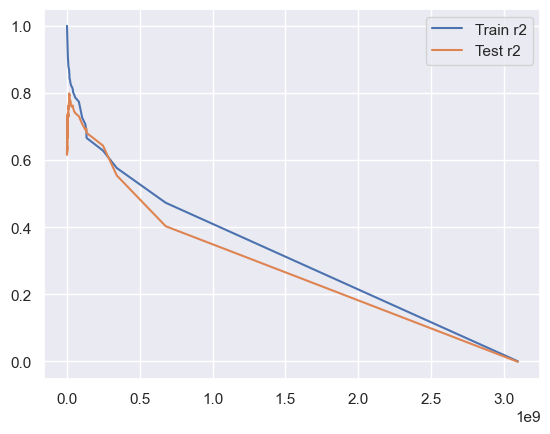

In [89]:
r2_train, r2_test = [],[]
max_alp = -1
max_score_test = -1
for i in alp:
    dtr = DecisionTreeRegressor(ccp_alpha=i)
    dtr.fit(Xtrain, ytrain)
    y_pred_train = dtr.predict(Xtrain)
    y_pred_test = dtr.predict(Xtest)
    
    r2_train.append(r2_score(ytrain, y_pred_train))
    r2_test.append(r2_score(ytest, y_pred_test))
    if max_score_test < r2_score(ytest, y_pred_test):
        max_score_test = r2_score(ytest, y_pred_test)
        max_alp = i
sns.set()
sns.lineplot(y = r2_train, x = alp, label = 'Train r2')
sns.lineplot(y = r2_test, x = alp, label = 'Test r2')
print(max_alp, max_score_test)

Для найденного значения $\alpha$ обучите дерево с параметром ccp_alpha равным $\alpha$ на тренировочных данных, сделайте предсказание на трейне и тесте и оцените качество предсказания на новых данных и переобучение модели.

Какая модель в итоге получилась лучше: с ограничением max_depth и min_samples_split или при помощи стрижки?

In [253]:
dtr = DecisionTreeRegressor(ccp_alpha = max_alp)
dtr.fit(Xtrain, ytrain)

y_pred_train = dtr.predict(Xtrain)
y_pred_test = dtr.predict(Xtest)

print(r2_score(ytrain, y_pred_train), r2_score(ytest, y_pred_test))

0.8556259974026101 0.794217022920247


### I tuned the alpha parameter, and using the pruning method significantly improved the model’s performance. This helped reduce overfitting and increase the overall accuracy of the model.